The NLR7301 is a supercritical airfoil which has been modified to a two-element configuration with a non-retractable flap. 
This configuration and the measurements were designed for the purpose of CFD validation[1]. 
The measurements were taken in 1979 and includes detailed pressure distributions, transition onset locations and someboundary layer velocity profiles for the angles of attack 6° and 13.1°. 
These measurements have been used extensively for another viscid-inviscid interaction method[2] as well as Navier Stokes codes, e.g.[3]. 
There is a single measurement set available, at a Reynolds Number of 2.51E6 and a Mach Number of .185, comprising a set of 16 lift and 3 drag values.

The airfoil coordinates were derived from a grid provided on this webpage https://www.kbwiki.ercoftac.org/w/index.php?title=UFR_3-01_Description for the project ECARP[7].

In [1]:
from collections import defaultdict
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viiflow as vf
import viiflowtools.vf_plots as vfp
import viiflowtools.vf_tools as vft
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.stats import linregress

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

import logging

logging.getLogger().setLevel(logging.INFO)

In [2]:
savefig = partial(plt.savefig, dpi=300, transparent=True, bbox_inches="tight")

In [3]:
ROUND_DECIMALS = 8
N_CHEBY = 100

In [4]:
# Read and panel airfoil data
main = vft.read_selig("NLR7301MainECARP.dat")
flap = vft.read_selig("NLR7301FlapECARP.dat")

MAIN = vft.repanel(main, 260)[:, ::-1]  # 180
FLAP0 = vft.repanel(flap, 220)[:, ::-1]  # 150

The authors note an offset in the change in distance between flap and main airfoil, as well as a change in twist on the flap. 
This change is applied below, by shifting and rotating the flap.
Such a modification was also used in the analysis in [6].

In [5]:
def rotate_around_center(points, deg, center):
    """Rotate points around a center in space.
    
    Parameters
    ----------
    points : np.array 2xN
    deg : float
    center : np.array 2x1
    
    Returns
    -------
    rotated : np.array 2xN
    """
    rad = np.deg2rad(deg)
    c, s = np.cos(rad), np.sin(rad)
    A = np.array([[c, s], [-s, c]])
    
    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    
    x = points
    rotated = ((A @ ((x.T - center.T).T)).T + center.T).T
    
    return rotated

In [6]:
# Rotate flap
CENTER = np.r_[0.94, -0.011]

# This angle seems to present an horizontal airfoil
DELTA_0 = -10
DELTA_EXP = 0
DELTAS = [DELTA_0, DELTA_EXP, 10, 20]

<IPython.core.display.Javascript object>


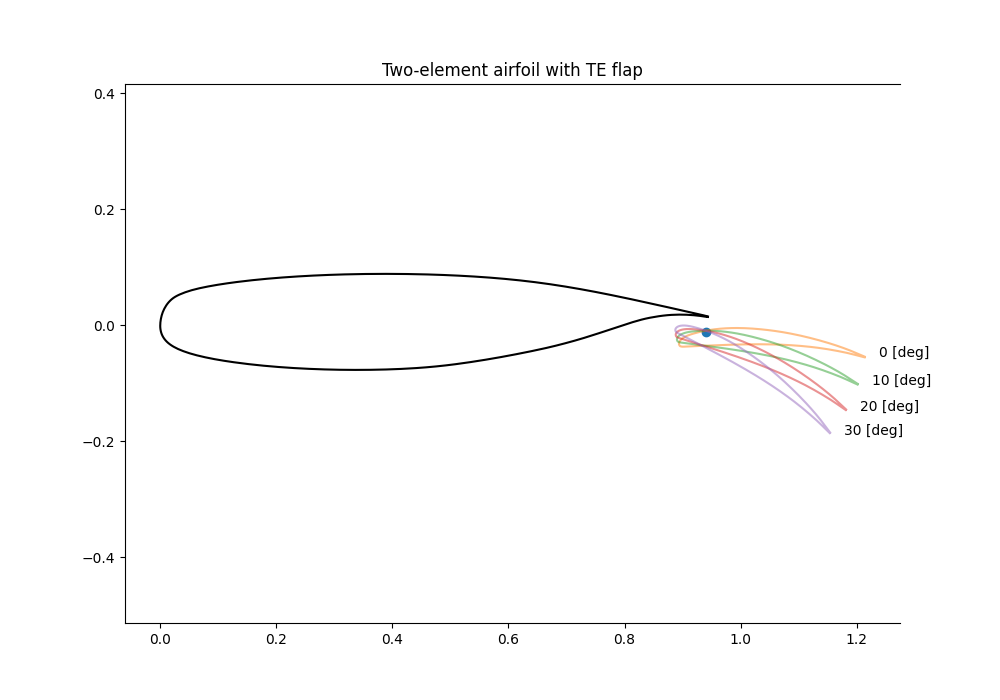

In [7]:
fig, ax = plt.subplots(1, 1)

# To accomodate text on the plot
ax.spines["right"].set_visible(False)

ax.plot(MAIN[0, :], MAIN[1, :], "-k")
ax.plot(CENTER[0], CENTER[1], "o")

for delta in DELTAS:

    FLAP = rotate_around_center(deg=delta, center=CENTER, points=FLAP0)
    FLAP[1, :] += 0.0025
    
    if delta == DELTA_0:
        C = MAIN[0,:].max()
        C_P = FLAP[0,:].max()
        CF = FLAP[0,:].max() - FLAP[0,:].min()

    # Plot geometry
    ax.plot(FLAP[0, :], FLAP[1, :], linestyle="-", alpha=0.5)
    te_flap = (FLAP.T[0]) * (1.02)
    ax.text(x=te_flap[0], y=te_flap[1], s=f"{delta-DELTA_0} [deg]")

# Final adjustments
ax.set_title(f"Two-element airfoil with TE flap")
ax.axis("equal")

savefig(fname="Multiairfoil_sketch.png")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [8]:
def compute_flap_load_ratio(panel, return_error=False):
    """Integrate the pressure distribution on each airfoil to
    obtain the load distribution w.r.t. to the overall lift coefficient.

    Parameters
    ----------
    panel : viiflow.panelCpl.panel_problem.PanelProblem
    return_error : bool
        Compute error between Cl computed via Cp integration and
        actual viiflow computation of Cl.

    Returns
    -------
    load_ratio : float
    """

    # Compute each element load contribution
    cls = integrate_cp_distribution(panel=panel)

    # Compute overall lift force
    cl = cls[1] + cls[0]

    # Compute error in cl computation
    computed_cl = panel.CL
    error = (computed_cl - cl) / computed_cl

    # Compute load ratio
    load_ratio = cls[1] / cl

    if return_error == True:
        result = (load_ratio, error)
    else:
        result = load_ratio

    return result


def create_chebyshev_nodes(a, b, N):
    """Create a Chebyshev node distribution to accumulate points
    near the LE and the TE, where curvature changes become important.

    Parameters
    ----------
    a : float, interval start
    b : float, interval end
    N : int

    Returns
    -------
    nodes : numpy.array
    """

    func = lambda i: np.cos(np.pi * float(2 * i) / (2 * N))
    nodes = np.array(list(map(func, range(N + 1))))

    mid_point = 0.5 * (a + b)
    scale = 0.5 * (b - a)

    nodes *= scale
    nodes += mid_point

    return nodes


def integrate_cp_distribution(panel):
    """Integrate cp distributions.

    Parameters
    ----------
    panel : viiflow.panelCpl.panel_problem.PanelProblem

    Returns
    -------
    float or dict
    """

    foils = panel.foils
    number_foils = len(foils)

    if number_foils == 1:

        _data = np.vstack([panel.foils[0].X[0, :], panel.cp]).T
        cp_df = pd.DataFrame(_data, columns=["X", "cp"])

        cl = _integrate_cp(cp_flatten=cp_df)

    elif number_foils == 2:

        cp_ranges = [
            range(0, panel.foils[0].N),
            range(panel.foils[0].N, panel.foils[0].N + panel.foils[1].N),
        ]

        cl = dict()
        for foil_idx in range(2):

            _indices = cp_ranges[foil_idx]
            _data = np.vstack([panel.foils[foil_idx].X[0, :], panel.cp[_indices]]).T
            cp_df = pd.DataFrame(_data, columns=["X", "cp"])

            _cl = _integrate_cp(cp_flatten=cp_df)

            cl[foil_idx] = _cl

    else:
        raise NotImplementedError("")

    return cl


def _integrate_cp(cp_flatten):
    """Integrate Cp distribution.

    Parameters
    ----------
    cp_flatten : pandas.DataFrame
        Two columns, X and Cp.

    Returns
    -------
    cl : float
    """

    cp_flatten = cp_flatten.round(ROUND_DECIMALS)

    # Split into upper and lower surfaces
    min_x_idx = cp_flatten.X.idxmin()

    upper = cp_flatten.loc[:min_x_idx].set_index("X")
    lower = cp_flatten.loc[min_x_idx:].set_index("X")

    # Create integration space
    max_x_upper = upper.index.max()
    max_x_lower = lower.index.max()

    max_x = min([max_x_upper, max_x_lower])
    min_x = upper.index.min()

    x_space = create_chebyshev_nodes(a=min_x, b=max_x, N=N_CHEBY)
    x_space = np.round(x_space, ROUND_DECIMALS)
    x_space = pd.Index(x_space)

    # Reindex upper and lower surface to same index
    index_upper = x_space.union(upper.index).sort_values()
    index_lower = x_space.union(lower.index).sort_values()

    upper_common = (
        upper.reindex(index_upper)
        .interpolate(method="index")
        .reindex(x_space)
        .sort_index(ascending=False)
    ).squeeze()

    lower_common = (
        lower.reindex(index_lower)
        .interpolate(method="index")
        .reindex(x_space)
        .sort_index(ascending=True)
    ).squeeze()

    upper_common.name = "cp_upper"
    lower_common.name = "cp_lower"

    # Compute difference and integrate
    cp = pd.concat([upper_common, lower_common], axis=1)

    cp["diff"] = cp["cp_upper"] - cp["cp_lower"]

    cl = simps(y=-cp["diff"], x=cp.index)

    return cl

In [9]:
def simulate(main, flap, delta, alpha=None):
    """Perform simulation.

    Parameters
    ----------
    main : np.array
    flap : np.array
    delta : float
        Degrees to rotate the flap
    alpha : float
        Angle of attack in degrees

    Returns
    -------
    results : dict
    panels :
    boundary_layer :
    """

    # Deflect flap
    flap_deflected = rotate_around_center(deg=delta, center=CENTER, points=flap)
    flap_deflected[1, :] += 0.0025

    # Prepare solver
    s = vf.setup(
        Re=REYNOLDS,
        Ncrit=NCRIT,
        Ma=MACH,
        Itermax=ITERMAX,
        Tolerance=TOL,
    )
    s.Silent = False  # Do not show information on convergence and iterations

    # RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
    s.ShearLagType = 1

    # Dictionary of results
    results = defaultdict(list)

    # Define angles of attack to solve
    if alpha is None:
        AOArange = np.linspace(AOA_START, AOA_END, num=AOA_N)
    else:
        AOArange = [alpha]

    for _alpha in AOArange:

        s.Alpha = _alpha

        # Create inviscid solution and initial boundary layer
        [p, bl, xn] = vf.init([main, flap_deflected], s)

        # Iterate towards convergence
        res = None
        grad = None
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad)

        resi = np.sqrt(np.dot(res.T, res))
        resi = np.log10(resi)

        load_ratio, cp_cl_error = compute_flap_load_ratio(panel=p, return_error=True)

        flag = bool(flag)

        results["AOA"].append(_alpha)
        results["delta"].append(delta)
        results["CL"].append(p.CL)
        results["load_ratio"].append(load_ratio)
        results["CL_error"].append(cp_cl_error)
        results["CLi"].append(p.CLi)
        results["CD"].append(bl[0].CD + bl[1].CD)
        results["CD_main"].append(bl[0].CD)
        results["residual"].append(resi)
        results["convergence"].append(flag)

    # Output results
    panels = p
    boundary_layer = bl

    return results, panels, boundary_layer

In [10]:
# Settings
REYNOLDS = 2.51e6
NCRIT = 8
MACH = 0.0
ITERMAX = 150
TOL = 1e-4

AOA_START = -10.0
AOA_END = 17
AOA_N = 12

results_raw = pd.DataFrame()
for delta in DELTAS:
    
    _results, _, _ = simulate(main = MAIN, flap = FLAP0, delta = delta)
    
    # Store as DF
    _results = pd.DataFrame(_results)    
    results_raw = results_raw.append(_results)

Iteration 20, |res| 0.000058, lam 0.500000
Iteration 150, |res| 0.001087, lam 0.500000
Iteration 15, |res| 0.000057, lam 0.920769
Iteration 20, |res| 0.000088, lam 0.523132
Iteration 18, |res| 0.000085, lam 0.500000
Iteration 15, |res| 0.000060, lam 0.951636
Iteration 15, |res| 0.000097, lam 0.500000
Iteration 14, |res| 0.000063, lam 0.500000
Iteration 15, |res| 0.000069, lam 0.500000
Iteration 15, |res| 0.000081, lam 0.500000
Iteration 15, |res| 0.000084, lam 0.500000
Iteration 21, |res| 0.000074, lam 0.500000
Iteration 150, |res| 0.000162, lam 0.500000
Iteration 16, |res| 0.000082, lam 0.500000
Iteration 17, |res| 0.000056, lam 0.500000
Iteration 19, |res| 0.000063, lam 0.500000
Iteration 15, |res| 0.000042, lam 1.000000
Iteration 13, |res| 0.000039, lam 1.000000
Iteration 16, |res| 0.000059, lam 0.500000
Iteration 13, |res| 0.000056, lam 1.000000
Iteration 16, |res| 0.000087, lam 0.500000
Iteration 15, |res| 0.000072, lam 0.500000
Iteration 17, |res| 0.000071, lam 0.575762
Iteration

 xi=0.297146,delta=0.000015,theta=0.000009,ue=2.263761,typ=laminar,
 res=[0.0249373,-0.160448,1.74782e-06]
 dx=[-1.74782e-06,0.0494053,1.74782e-06]
 x=[9.32047e-06,2.26376,0.00296837] 
 lam=1.000000 H=1.623598 HS=1.770272 US=0.000000.

 xi=0.297146,delta=0.000015,theta=0.000009,ue=2.263761,typ=laminar,
 res=[0.0249373,-0.160448,1.74782e-06]
 dx=[-1.74782e-06,0.0494053,1.74782e-06]
 x=[9.32047e-06,2.26376,0.00296837] 
 lam=1.000000 H=1.623598 HS=1.770272 US=0.000000.

 xi=0.298102,delta=0.000009,theta=0.000006,ue=3.381651,typ=laminar,
 res=[0.0898962,-0.162458,-2.0837e-19]
 dx=[8.15765e-07,0.00731804,-1.56697e-06]
 x=[5.54598e-06,3.38165,0.00296662] 
 lam=1.000000 H=1.637152 HS=1.765500 US=0.000000.

 xi=0.298102,delta=0.000009,theta=0.000006,ue=3.378715,typ=laminar,
 res=[0.0857679,-0.155041,1.44739e-06]
 dx=[-1.58547e-06,0.103623,1.15407e-06]
 x=[5.58308e-06,3.37871,0.00296807] 
 lam=0.880349 H=1.626273 HS=1.769324 US=0.000000.

 xi=0.298735,delta=0.000005,theta=0.000003,ue=5.501292,t

 xi=0.303714,delta=0.000003,theta=0.000002,ue=10.330345,typ=laminar,
 res=[0.153091,-0.261794,-2.0837e-19]
 dx=[2.00924e-07,0.161321,-3.9536e-07]
 x=[1.78236e-06,10.3303,0.00302808] 
 lam=1.000000 H=1.791169 HS=1.716710 US=0.000000.

 xi=0.303714,delta=0.000003,theta=0.000002,ue=10.330345,typ=laminar,
 res=[0.153091,-0.261794,-2.0837e-19]
 dx=[2.00924e-07,0.161321,-3.9536e-07]
 x=[1.78236e-06,10.3303,0.00302808] 
 lam=1.000000 H=1.791169 HS=1.716710 US=0.000000.

 xi=0.303718,delta=0.000003,theta=0.000002,ue=10.514061,typ=laminar,
 res=[0.101122,-0.504178,-2.0837e-19]
 dx=[2.64063e-07,0.0982461,2.0837e-19]
 x=[2.21247e-06,10.5141,0.00302808] 
 lam=1.000000 H=1.432380 HS=1.847210 US=0.000000.

 xi=0.303718,delta=0.000003,theta=0.000002,ue=10.429329,typ=laminar,
 res=[0.154434,-0.26362,-2.0837e-19]
 dx=[1.99326e-07,0.163212,-3.33934e-08]
 x=[1.76722e-06,10.4293,0.00302808] 
 lam=1.000000 H=1.793271 HS=1.716108 US=0.000000.

 xi=0.303720,delta=0.000003,theta=0.000002,ue=10.531039,typ=lami

 xi=0.303723,delta=0.000003,theta=0.000002,ue=9.570570,typ=laminar,
 res=[0.0281744,-0.101114,1.36533e-07]
 dx=[-1.36533e-07,-0.043797,1.36533e-07]
 x=[1.98639e-06,9.57057,0.00302822] 
 lam=1.000000 H=1.703586 HS=1.743269 US=0.000000.

 xi=0.303723,delta=0.000003,theta=0.000002,ue=9.591343,typ=laminar,
 res=[0.0111896,-0.047634,9.01903e-08]
 dx=[-9.01903e-08,-0.0223085,-4.59584e-09]
 x=[2.05872e-06,9.59134,0.00302817] 
 lam=1.000000 H=1.643736 HS=1.763211 US=0.000000.

 xi=0.303723,delta=0.000003,theta=0.000002,ue=9.516914,typ=laminar,
 res=[0.0515557,-0.100151,-2.0837e-19]
 dx=[1.51319e-07,0.0728522,-2.6546e-07]
 x=[2.00992e-06,9.51691,0.00302808] 
 lam=1.000000 H=1.695988 HS=1.745717 US=0.000000.

 xi=0.303723,delta=0.000003,theta=0.000002,ue=9.515455,typ=laminar,
 res=[0.00868314,-0.0426224,8.40053e-08]
 dx=[-8.40053e-08,-0.0285526,8.40053e-08]
 x=[2.11353e-06,9.51546,0.00302817] 
 lam=1.000000 H=1.612850 HS=1.774116 US=0.000000.

 xi=0.303723,delta=0.000003,theta=0.000002,ue=9.4871

 xi=0.303722,delta=0.000004,theta=0.000003,ue=8.498541,typ=laminar,
 res=[0.0573128,-0.258212,-2.0837e-19]
 dx=[2.40782e-07,0.052604,-1.24106e-07]
 x=[2.53225e-06,8.49854,0.00302808] 
 lam=1.000000 H=1.483419 HS=1.824798 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000002,ue=8.324243,typ=laminar,
 res=[0.0753514,-0.244252,2.52943e-07]
 dx=[-2.52943e-07,-0.0554932,2.52943e-07]
 x=[2.12908e-06,8.32424,0.00302834] 
 lam=1.000000 H=1.779864 HS=1.719972 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=8.455691,typ=laminar,
 res=[0.176311,-0.873014,-2.0837e-19]
 dx=[4.85439e-07,0.0842219,2.0837e-19]
 x=[2.79739e-06,8.45569,0.00302808] 
 lam=0.960434 H=1.354645 HS=1.884299 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000002,ue=8.287099,typ=laminar,
 res=[0.0370518,-0.0838125,-2.0837e-19]
 dx=[1.60988e-07,-0.0308336,2.0837e-19]
 x=[2.31757e-06,8.2871,0.00302808] 
 lam=1.000000 H=1.649644 HS=1.761174 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=8.364157,typ=l

 xi=0.303722,delta=0.000004,theta=0.000003,ue=7.386609,typ=laminar,
 res=[0.13307,-0.665766,-2.0837e-19]
 dx=[4.63825e-07,0.0617795,-1.66944e-07]
 x=[3.06077e-06,7.38661,0.00302808] 
 lam=1.000000 H=1.384588 HS=1.869571 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=7.290715,typ=laminar,
 res=[0.0601997,-0.131534,3.99327e-07]
 dx=[-3.99327e-07,-0.0208565,3.99327e-07]
 x=[2.76051e-06,7.29071,0.00302848] 
 lam=1.000000 H=1.550499 HS=1.797485 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=7.268392,typ=laminar,
 res=[0.037563,-0.135317,-2.0837e-19]
 dx=[2.18947e-07,0.0335945,-1.99148e-07]
 x=[2.77397e-06,7.26839,0.00302808] 
 lam=1.000000 H=1.542978 HS=1.800432 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=7.149788,typ=laminar,
 res=[0.0324664,-0.136824,2.16014e-07]
 dx=[-2.16014e-07,-0.0331154,2.16014e-07]
 x=[2.55893e-06,7.14979,0.0030283] 
 lam=1.000000 H=1.689457 HS=1.747840 US=0.000000.

 xi=0.303722,delta=0.000004,theta=0.000003,ue=7.230079,typ

 xi=0.303721,delta=0.000005,theta=0.000003,ue=6.309824,typ=laminar,
 res=[0.0439008,-0.122995,-2.0837e-19]
 dx=[2.62095e-07,-0.0354845,2.0837e-19]
 x=[3.06191e-06,6.30982,0.00302808] 
 lam=1.000000 H=1.583543 HS=1.784868 US=0.000000.

 xi=0.303721,delta=0.000005,theta=0.000003,ue=6.234302,typ=laminar,
 res=[0.0444419,-0.125006,-2.0837e-19]
 dx=[2.68936e-07,0.0314636,-3.23641e-07]
 x=[3.09687e-06,6.2343,0.00302808] 
 lam=1.000000 H=1.582782 HS=1.785153 US=0.000000.

 xi=0.303721,delta=0.000005,theta=0.000003,ue=6.261613,typ=laminar,
 res=[0.0752612,-0.134378,5.40441e-07]
 dx=[-5.40441e-07,-0.00495488,5.40441e-07]
 x=[3.10861e-06,6.26161,0.00302862] 
 lam=1.000000 H=1.576806 HS=1.787397 US=0.000000.

 xi=0.303721,delta=0.000005,theta=0.000003,ue=6.196918,typ=laminar,
 res=[0.130517,-0.227909,-2.0837e-19]
 dx=[3.63015e-07,0.0810731,-6.24955e-07]
 x=[2.86283e-06,6.19692,0.00302808] 
 lam=1.000000 H=1.730959 HS=1.734646 US=0.000000.

 xi=0.303721,delta=0.000005,theta=0.000003,ue=6.160408,ty

Iteration 93, |res| 0.000098, lam 0.500000


 xi=0.292944,delta=0.000016,theta=0.000010,ue=2.043282,typ=laminar,
 res=[0.0257539,-0.144046,1.88542e-06]
 dx=[-1.88542e-06,0.0485017,1.88542e-06]
 x=[9.76677e-06,2.04328,0.00289743] 
 lam=1.000000 H=1.616907 HS=1.772659 US=0.000000.

 xi=0.292944,delta=0.000016,theta=0.000010,ue=2.043282,typ=laminar,
 res=[0.0257539,-0.144046,1.88542e-06]
 dx=[-1.88542e-06,0.0485017,1.88542e-06]
 x=[9.76677e-06,2.04328,0.00289743] 
 lam=1.000000 H=1.616907 HS=1.772659 US=0.000000.

 xi=0.293805,delta=0.000009,theta=0.000006,ue=3.069622,typ=laminar,
 res=[0.0824365,-0.149601,-2.0837e-19]
 dx=[8.14467e-07,0.00426555,-1.41646e-06]
 x=[5.76837e-06,3.06962,0.0029312] 
 lam=1.000000 H=1.642608 HS=1.763602 US=0.000000.

 xi=0.293805,delta=0.000009,theta=0.000006,ue=3.070680,typ=laminar,
 res=[0.0842198,-0.151991,-2.0837e-19]
 dx=[8.1882e-07,0.00562108,-1.4715e-06]
 x=[5.75757e-06,3.07068,0.0029312] 
 lam=1.000000 H=1.645690 HS=1.762536 US=0.000000.

 xi=0.294371,delta=0.000006,theta=0.000004,ue=5.001596,typ

 xi=0.302969,delta=0.000002,theta=0.000001,ue=24.762270,typ=laminar,
 res=[0.0155359,-0.0397254,-2.0837e-19]
 dx=[3.32357e-08,0.100257,2.0837e-19]
 x=[9.68321e-07,24.7623,0.00302808] 
 lam=1.000000 H=1.689021 HS=1.747983 US=0.000000.

 xi=0.302969,delta=0.000002,theta=0.000001,ue=25.148883,typ=laminar,
 res=[0.0912074,-0.207578,1.30035e-07]
 dx=[-1.30035e-07,-0.455454,1.16265e-07]
 x=[1.04385e-06,25.1489,0.00302821] 
 lam=1.000000 H=1.566815 HS=1.791189 US=0.000000.

 xi=0.302973,delta=0.000002,theta=0.000001,ue=22.910074,typ=laminar,
 res=[0.0159189,-0.0418511,-2.0837e-19]
 dx=[3.65748e-08,0.0951693,2.0837e-19]
 x=[1.02968e-06,22.9101,0.00302808] 
 lam=1.000000 H=1.679038 HS=1.751264 US=0.000000.

 xi=0.302973,delta=0.000002,theta=0.000001,ue=22.972750,typ=laminar,
 res=[0.0107748,-0.0457083,3.59041e-08]
 dx=[-3.59041e-08,-0.133566,3.59041e-08]
 x=[1.05155e-06,22.9728,0.00302812] 
 lam=1.000000 H=1.644121 HS=1.763078 US=0.000000.

 xi=0.302976,delta=0.000002,theta=0.000001,ue=21.18946

 xi=0.303027,delta=0.000003,theta=0.000002,ue=9.239549,typ=laminar,
 res=[0.0254664,-0.111868,1.40228e-07]
 dx=[-1.40228e-07,-0.0953026,-1.77491e-07]
 x=[2.05409e-06,9.23955,0.00302822] 
 lam=1.000000 H=1.671953 HS=1.753619 US=0.000000.

 xi=0.303027,delta=0.000003,theta=0.000002,ue=9.324522,typ=laminar,
 res=[0.0647533,-0.163914,2.95257e-07]
 dx=[-2.95257e-07,-0.0793809,2.7934e-07]
 x=[2.20265e-06,9.32452,0.00302838] 
 lam=1.000000 H=1.559188 HS=1.794116 US=0.000000.

 xi=0.303060,delta=0.000003,theta=0.000002,ue=10.669412,typ=laminar,
 res=[0.0249132,-0.0591471,-2.0837e-19]
 dx=[9.78277e-08,0.0578659,-1.59251e-07]
 x=[1.84652e-06,10.6694,0.00302808] 
 lam=1.000000 H=1.664905 HS=1.755983 US=0.000000.

 xi=0.303060,delta=0.000003,theta=0.000002,ue=10.703806,typ=laminar,
 res=[0.0186514,-0.0648536,-2.0837e-19]
 dx=[9.52744e-08,0.0348766,2.0837e-19]
 x=[1.93944e-06,10.7038,0.00302808] 
 lam=1.000000 H=1.585140 HS=1.784272 US=0.000000.

 xi=0.303074,delta=0.000003,theta=0.000002,ue=11.353

Iteration 89, |res| 0.000083, lam 0.578504


 xi=0.290048,delta=0.000016,theta=0.000010,ue=1.962599,typ=laminar,
 res=[0.0224879,-0.129613,1.73685e-06]
 dx=[-1.73685e-06,0.0418763,1.73685e-06]
 x=[9.88677e-06,1.9626,0.00289728] 
 lam=1.000000 H=1.596814 HS=1.779949 US=0.000000.

 xi=0.290048,delta=0.000016,theta=0.000010,ue=1.967269,typ=laminar,
 res=[0.0286757,-0.13888,1.9812e-06]
 dx=[-1.9812e-06,0.050012,1.9812e-06]
 x=[9.77539e-06,1.96727,0.00289753] 
 lam=1.000000 H=1.615009 HS=1.773339 US=0.000000.

 xi=0.290861,delta=0.000009,theta=0.000006,ue=2.953886,typ=laminar,
 res=[0.064308,-0.115618,1.31309e-06]
 dx=[-1.31309e-06,0.0569674,8.86456e-07]
 x=[5.90651e-06,2.95389,0.00289686] 
 lam=1.000000 H=1.603721 HS=1.777422 US=0.000000.

 xi=0.290861,delta=0.000009,theta=0.000006,ue=2.946405,typ=laminar,
 res=[0.051125,-0.10968,-2.0837e-19]
 dx=[6.95671e-07,-0.00360377,-9.94395e-07]
 x=[5.93571e-06,2.94641,0.00289555] 
 lam=1.000000 H=1.595833 HS=1.780310 US=0.000000.

 xi=0.291393,delta=0.000006,theta=0.000003,ue=4.908667,typ=lami

 xi=0.302714,delta=0.000020,theta=0.000012,ue=2.092615,typ=laminar,
 res=[0.0649247,-0.154103,9.01042e-08]
 dx=[2.15263e-06,-0.0358094,-2.59744e-06]
 x=[1.24677e-05,2.09261,0.00301544] 
 lam=0.965310 H=1.626528 HS=1.769233 US=0.000000.

 xi=0.302793,delta=0.000020,theta=0.000012,ue=2.106404,typ=laminar,
 res=[0.0809723,-0.169503,3.04092e-06]
 dx=[-7.0916e-06,0.167355,7.08382e-06]
 x=[1.21459e-05,2.1064,0.00301839] 
 lam=0.428178 H=1.663914 HS=1.756317 US=0.000000.

 xi=0.302940,delta=0.000020,theta=0.000012,ue=2.082237,typ=laminar,
 res=[0.0693913,-0.176489,2.99824e-06]
 dx=[-5.0577e-06,0.109588,5.03156e-06]
 x=[1.19502e-05,2.08224,0.00301834] 
 lam=0.590692 H=1.682621 HS=1.750082 US=0.000000.

 xi=0.302876,delta=0.000021,theta=0.000013,ue=1.969646,typ=laminar,
 res=[0.0582027,-0.145541,4.60973e-08]
 dx=[2.25087e-06,-0.0322439,-2.76671e-06]
 x=[1.32802e-05,1.96965,0.00301539] 
 lam=0.983339 H=1.593845 HS=1.781042 US=0.000000.

 xi=0.303016,delta=0.000020,theta=0.000011,ue=2.094059,typ=

 xi=0.313392,delta=0.000000,theta=0.000000,ue=2212466.094721,typ=laminar,
 res=[0.910935,-2.33513,1.67235e-10]
 dx=[-1.67235e-10,-109058,1.67235e-10]
 x=[1.44716e-09,2.21247e+06,0.00312312] 
 lam=1.000000 H=1.951263 HS=1.675272 US=0.000000.

 xi=0.313392,delta=0.000000,theta=0.000000,ue=6102266.064208,typ=laminar,
 res=[0.616214,-1.59624,1.55854e-19]
 dx=[8.0845e-11,214790,1.16588e-11]
 x=[9.9478e-10,6.10227e+06,0.00312312] 
 lam=1.000000 H=1.703159 HS=1.743406 US=0.000000.

 xi=0.313392,delta=0.000000,theta=0.000000,ue=15231851.147707,typ=laminar,
 res=[0.512755,-1.40305,4.47381e-11]
 dx=[-4.47381e-11,-558604,4.47381e-11]
 x=[5.41959e-10,1.52319e+07,0.00312312] 
 lam=1.000000 H=1.875715 HS=1.693759 US=0.000000.

 xi=0.313392,delta=0.000000,theta=0.000000,ue=44031731.483148,typ=laminar,
 res=[2.71275,-7.98833,7.76442e-14]
 dx=[6.74274e-11,3.62551e+06,-2.27073e-11]
 x=[4.03181e-10,4.40317e+07,0.00312312] 
 lam=0.996581 H=1.512811 HS=1.812541 US=0.000000.

 xi=0.313392,delta=0.000000,the

Iteration 150, |res| 2261.422641, lam 0.000000


 xi=0.292213,delta=0.000016,theta=0.000010,ue=1.897003,typ=laminar,
 res=[0.0331168,-0.166127,2.01291e-06]
 dx=[-2.01291e-06,0.0452867,2.01291e-06]
 x=[9.64702e-06,1.897,0.00289756] 
 lam=1.000000 H=1.625901 HS=1.769455 US=0.000000.

 xi=0.292213,delta=0.000016,theta=0.000010,ue=1.897003,typ=laminar,
 res=[0.0331168,-0.166127,2.01291e-06]
 dx=[-2.01291e-06,0.0452867,2.01291e-06]
 x=[9.64702e-06,1.897,0.00289756] 
 lam=1.000000 H=1.625901 HS=1.769455 US=0.000000.

 xi=0.293134,delta=0.000009,theta=0.000006,ue=2.843702,typ=laminar,
 res=[0.0361087,-0.148737,-2.0837e-19]
 dx=[6.81843e-07,-0.0476616,2.0837e-19]
 x=[6.35936e-06,2.8437,0.0029312] 
 lam=1.000000 H=1.479875 HS=1.826307 US=0.000000.

 xi=0.293134,delta=0.000009,theta=0.000005,ue=2.876593,typ=laminar,
 res=[0.150955,-0.500343,1.61842e-06]
 dx=[-4.42776e-06,0.121954,3.87526e-06]
 x=[4.87154e-06,2.87659,0.00293282] 
 lam=0.275057 H=1.931844 HS=1.679852 US=0.000000.

 xi=0.293728,delta=0.000006,theta=0.000004,ue=4.781227,typ=lamina

 xi=0.303435,delta=0.000021,theta=0.000012,ue=1.987001,typ=laminar,
 res=[0.059994,-0.206224,3.19905e-06]
 dx=[-3.87635e-06,0.067667,2.99133e-06]
 x=[1.19946e-05,1.987,0.00301855] 
 lam=0.773577 H=1.719076 HS=1.738352 US=0.000000.

 xi=0.304709,delta=0.000000,theta=0.000000,ue=106100180.085533,typ=laminar,
 res=[0.976673,-0.330027,-2.0837e-19]
 dx=[4.39287e-11,-1.85266e+06,2.0837e-19]
 x=[2.8683e-10,1.061e+08,0.00300686] 
 lam=1.000000 H=1.187090 HS=1.978150 US=0.000000.

 xi=0.303435,delta=0.000021,theta=0.000012,ue=1.987001,typ=laminar,
 res=[0.0599938,-0.206225,3.19904e-06]
 dx=[-3.87634e-06,0.0676667,2.99133e-06]
 x=[1.19946e-05,1.987,0.00301855] 
 lam=0.773580 H=1.719077 HS=1.738352 US=0.000000.

 xi=0.304709,delta=0.000000,theta=0.000000,ue=291937286.269139,typ=laminar,
 res=[2.22897,-1.07329,-2.0837e-19]
 dx=[-1.00063e-10,3.33669e+07,2.0837e-19]
 x=[1.29528e-10,2.91937e+08,0.00300686] 
 lam=0.323615 H=1.577235 HS=1.787236 US=0.000000.

 xi=0.303435,delta=0.000021,theta=0.000012,

 xi=0.308386,delta=0.000019,theta=0.000011,ue=2.161642,typ=laminar,
 res=[0.0724928,-0.203409,2.79997e-06]
 dx=[-3.99995e-06,0.082791,3.93936e-06]
 x=[1.11261e-05,2.16164,0.00306833] 
 lam=0.695387 H=1.686076 HS=1.748946 US=0.000000.

 xi=0.310037,delta=0.000018,theta=0.000010,ue=2.254725,typ=laminar,
 res=[0.0745631,-0.327638,2.42344e-06]
 dx=[-2.67773e-06,0.0416353,2.67773e-06]
 x=[9.69376e-06,2.25472,0.00308923] 
 lam=0.905035 H=1.857197 HS=1.698574 US=0.000000.

 xi=0.310037,delta=0.000018,theta=0.000010,ue=2.254726,typ=laminar,
 res=[0.0745634,-0.327639,2.42345e-06]
 dx=[-2.67777e-06,0.0416362,2.67777e-06]
 x=[9.69378e-06,2.25473,0.00308923] 
 lam=0.905023 H=1.857198 HS=1.698573 US=0.000000.

 xi=0.310022,delta=0.000011,theta=0.000006,ue=3.429494,typ=laminar,
 res=[0.100739,-0.204855,1.62268e-06]
 dx=[-1.63977e-06,0.0517918,7.46262e-07]
 x=[6.4089e-06,3.42949,0.00308843] 
 lam=0.977104 H=1.685463 HS=1.749147 US=0.000000.

 xi=0.310018,delta=0.000006,theta=0.000005,ue=5.808475,typ=

 xi=0.310423,delta=0.000000,theta=0.000000,ue=20212661136300515923066880.000000,typ=turbulent,
 res=[-477.663,-241.865,7.70238e-06]
 dx=[4.4019e-11,-2.66991e+26,-0.0349596]
 x=[6.90878e-11,2.02127e+25,0.000903055] 
 lam=0.006458 H=1.262514 HS=1.821152 US=0.682461.

 xi=0.310422,delta=0.000000,theta=0.000000,ue=1335346085.730148,typ=laminar,
 res=[2.92675,-6.2624,-85702.5]
 dx=[5.39566e-12,7.69296e+07,309707]
 x=[4.70286e-11,1.33535e+09,3.20348e+06] 
 lam=1.000000 H=2.016315 HS=1.660751 US=0.000000.

 xi=0.310422,delta=0.000000,theta=0.000000,ue=3715391703.238644,typ=laminar,
 res=[1.56039,-3.5292,-264771]
 dx=[3.04311e-12,1.6945e+08,-216125]
 x=[3.14756e-11,3.71539e+09,5.0983e+06] 
 lam=1.000000 H=1.807580 HS=1.712057 US=0.000000.

 xi=0.310422,delta=0.000000,theta=0.000000,ue=484426591629331988964224008192.000000,typ=turbulent,
 res=[-819.534,-314.588,4.06849e-06]
 dx=[-2.41448e-12,5.18934e+30,0.00146406]
 x=[2.5963e-11,4.84427e+29,0.000702101] 
 lam=0.015558 H=1.314824 HS=1.793398 US

Iteration 150, |res| 22419497995.885979, lam 0.000000


In [11]:
def compute_lift_polar_parameters(simulation_results):
    """Compute lift slope, at zero angle of attack and maximum.

    Parameters
    ----------
    simulation_results : pandas.DataFrame

    Returns
    -------
    cl_alpha : float
    cl_max : float
    cl_zero_aoa : float
    """

    cl_max = simulation_results["CL"].max()

    # Remove outliers
    cl_max_idx = simulation_results["CL"].idxmax()
    cl_min_idx = simulation_results["CL"].idxmin()
    _results = simulation_results.loc[cl_min_idx + 1 : cl_max_idx - 1]

    # Create linear regression
    x = np.deg2rad(_results["AOA"])
    y = _results["CL"]
    linreg_result = linregress(x=x, y=y)

    # Round data
    cl_zero_aoa = np.round(linreg_result.intercept, 3)
    cl_alpha = np.round(linreg_result.slope, 3)
    cl_max = np.round(cl_max, 3)

    results = {"slope": cl_alpha, "cl_max": cl_max, "cl_zero": cl_zero_aoa}

    return results

In [12]:
results_per_delta = dict()

torenbeek = dict()

for delta in DELTAS:
    
    # Filter results
    mask_delta = results_raw["delta"] == delta
    mask_conv = results_raw["convergence"] == True
    mask = mask_delta & mask_conv
    
    _results = results_raw.loc[mask]
    
    cl_parameters = compute_lift_polar_parameters(simulation_results=_results)
    
    torenbeek[delta] = cl_parameters.copy()
    
    results_per_delta[delta] = _results.copy()
    
torenbeek_df = pd.DataFrame(torenbeek).T
torenbeek_df.index.name = "delta"

base_polar_data = torenbeek_df.loc[DELTA_0].copy()

<IPython.core.display.Javascript object>


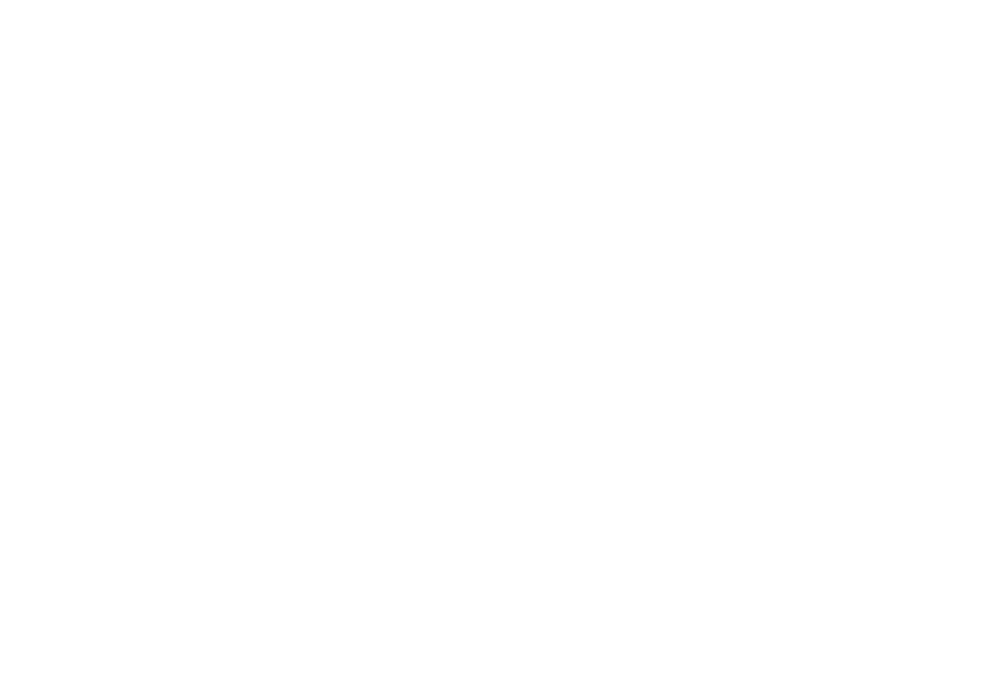

In [13]:
# LIFT
LIFT_EXP = np.genfromtxt("NLRLIFTSLOPE.csv", delimiter=",", names=True)

fig, ax = plt.subplots(1, 2)

color_exp = "black"

# Plot experimental result
ax[0].plot(
    LIFT_EXP["MEAS_X"],
    LIFT_EXP["MEAS_Y"],
    marker="o",
    fillstyle="none",
    linestyle="None",
    color=color_exp,
    label="Experimental Lift",
)

for delta in DELTAS:

    # Unpack results
    _results = results_per_delta[delta]
    delta_eff = delta - DELTA_0

    if delta == DELTA_EXP:
        color = color_exp
        linewidth = 1.0
    else:
        color = None
        linewidth = 0.5

    ax[0].plot(
        _results["AOA"],
        _results["CL"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta_eff}$",
    )

ax[0].set_xlabel("$\\alpha$ [deg]")
ax[0].set_ylabel("$c_l$")
ax[0].legend()
ax[0].grid()

# DRAG
DARG_EXP = np.genfromtxt("NLRDRAGSLOPE.csv", delimiter=",", names=True)

ax[1].plot(
    DARG_EXP["MEAS_X"],
    DARG_EXP["MEAS_Y"],
    marker="o",
    fillstyle="none",
    linestyle="None",
    color=color_exp,
    label="Experimental Drag",
)

for delta in DELTAS:

    # Unpack results
    _results = results_per_delta[delta]
    delta_eff = delta - DELTA_0

    if delta == DELTA_EXP:
        color = color_exp
        linewidth = 1.0
    else:
        color = None
        linewidth = 0.5

    ax[1].plot(
        _results["AOA"],
        _results["CD"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta_eff}$",
    )

ax[1].set_xlabel("$\\alpha$ [deg]")
ax[1].set_ylabel("$c_d$")
ax[1].legend()
ax[1].grid()

savefig(fname="lift_drag_polar.png")

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [14]:
DISPLACEMENT = 0.1

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax, data, plot_transition=False):

    plotter_cp = partial(ax.plot, linestyle="None", color="tab:blue", marker="o")
    plotter_transition = partial(
        ax.plot,
        linestyle="None",
        color="tab:orange",
        marker="D",
    )

    plotter_cp(
        data["EXPMAINCP_X"],
        data["EXPMAINCP_Y"],
        label="Experiment",
    )
    plotter_cp(
        data["EXPFLAPCP_X"] + DISPLACEMENT,
        data["EXPFLAPCP_Y"],
    )
    
    if plot_transition == True:
        plotter_transition(
            data["EXPMAINTR_X"],
            data["EXPMAINTR_Y"],
            label="Experimental transition region",
        )
        plotter_transition(
            data["EXPFLAPTR_X"] + DISPLACEMENT,
            data["EXPFLAPTR_Y"],
        )


# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax, p, bl, plot_transition=False):

    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0, p.foils[0].N), range(p.foils[0].N, p.foils[0].N + p.foils[1].N)]

    plotter_cp = partial(ax.plot, color="tab:blue", marker="None", linestyle="--")
    plotter_tr = partial(ax.plot, color="tab:red", marker="v")

    plotter_cp(
        np.array(p.foils[0].X[0, :]),
        -p.cp[IMF[0]],
        label="Viscous calculation",
    )

    plotter_cp(
        np.array(p.foils[1].X[0, :] + DISPLACEMENT),
        -p.cp[IMF[1]],
    )

    if plot_transition == True:
        # Small hack, only works for TWO elements
        for k in range(2):
            tr_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            tr_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            cp_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )
            cp_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )

            plotter_tr(tr_lo, -cp_lo, label="Numerical transition point")
            plotter_tr(tr_up, -cp_up)

<IPython.core.display.Javascript object>


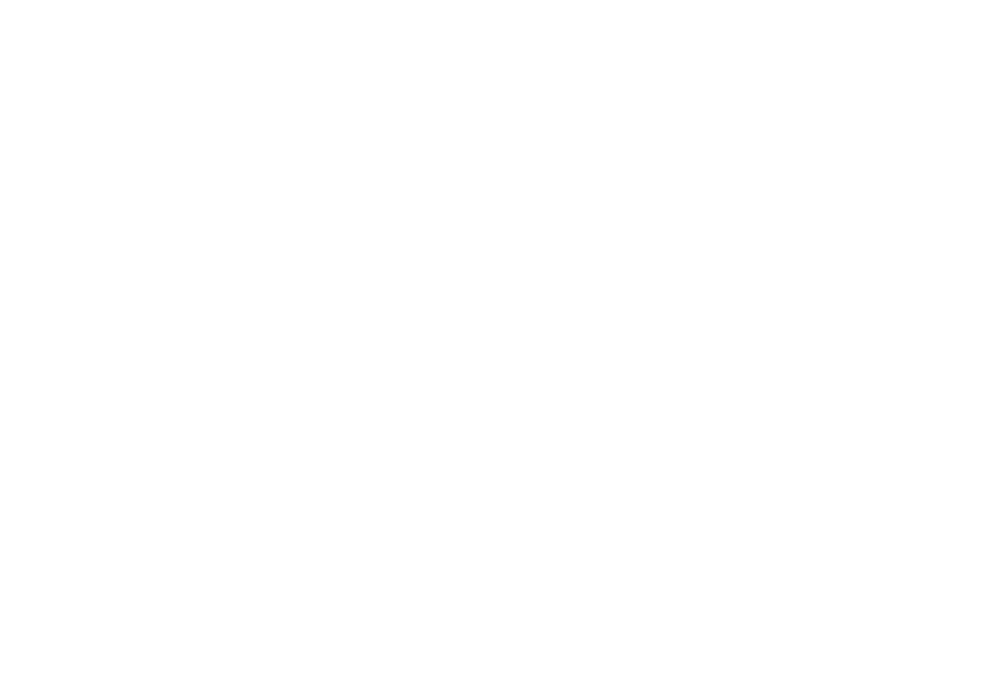

Iteration 11, |res| 0.000043, lam 1.000000
Iteration 16, |res| 0.000061, lam 0.500000


In [15]:
cp_files = ["NLRCP55.csv", "NLRCP126.csv"]
alphas = [6.0, 13.1]

fig, axes = plt.subplots(1,2, sharey=True)
axes = axes.flatten()

for ax, alpha, cp_file in zip(axes, alphas, cp_files):

    # Experiment and simulation
    cp_exp = np.genfromtxt(cp_file, delimiter=",", names=True)
    _results, p, bl = simulate(main=MAIN, flap=FLAP0, delta=DELTA_EXP, alpha=alpha)

    plot_cp_exp(ax, cp_exp)
    plot_cp(ax, p, bl)

    ax.set_xlabel("$x/c$")
    ax.set_ylabel("$-c_p$")
    ax.set_title(f"$\\alpha$={alpha} [deg]")
    ax.legend()
    ax.grid()
    
savefig("pressure_distribution_validation.png")

## Torenbeek extension

In [16]:
empirical_chord_extension = pd.read_csv(filepath_or_buffer="chord_extension.csv")

# Adjuste scale
_col = "chord_extension"
empirical_chord_extension[_col] = empirical_chord_extension[_col].div(100)

# add zero
cols = empirical_chord_extension.columns
empirical_chord_extension = empirical_chord_extension.append(
    pd.DataFrame([[0.0, 0.0]], columns=cols)
)
empirical_chord_extension = empirical_chord_extension.sort_values(by="delta")

# Create constants
EMPIRICAL_CHORD_EXT = empirical_chord_extension.copy()
ETA = pd.read_csv(filepath_or_buffer="flap_effectiveness.csv")

In [17]:
def compute_chord_extension(cf, delta):
    
    values = EMPIRICAL_CHORD_EXT.values.T
    x = values[0, :]
    y = values[1, :]

    f = interp1d(x=x, y=y)
    
    ext = cf * f(delta)

    return ext

def compute_eta_factor(delta):

    values = ETA.values.T
    x = values[0, :]
    y = values[1, :]

    f = interp1d(x=x, y=y)
    
    eta = f(delta)

    return eta

def compute_alpha_delta(cf, c):

    theta_f = 2.0 * (cf / c) - 1.0
    theta_f = np.arccos(theta_f)

    alpha_delta = 1.0 - (theta_f - np.sin(theta_f)) / np.pi

    return alpha_delta

In [18]:
def _torenbeek_prediction(cf, c, cl_alpha, delta, use_eta=True):

    delta = np.deg2rad(delta)
    
    if use_eta == True:
        factor = compute_eta_factor(delta)
    else:
        factor = 1.0

    alpha_delta = compute_alpha_delta(cf=cf, c=c)

    prediction = factor * alpha_delta * cl_alpha * delta

    return prediction

In [48]:
# Get base results
cl_alpha = base_polar_data["slope"]
cl0 = base_polar_data["cl_zero"]
cl_alpha, cl0

prediction = []
_appender = prediction.append

_deltas = torenbeek_df.index

_predictor = partial(
    _torenbeek_prediction,
    cl_alpha=cl_alpha,
)

for _delta in _deltas:

    delta = _delta - DELTA_0
    
    # Compute chord extension
    cf_ext = compute_chord_extension(cf=CF, delta=delta)
    cf_p = CF + cf_ext
    c_p = C + cf_ext

    # Compute increment with and without empirical adjustment
    increment = _predictor(c=C, cf=cf_p, delta=delta, use_eta=False)
    increment_eta = _predictor(c=C, cf=cf_p, delta=delta, use_eta=True)

    increment = increment * (c_p / C) + cl0 * (c_p / C - 1.0)
    increment_eta = increment_eta * (c_p / C) + cl0 * (c_p / C - 1.0)

    _appender((delta, increment, increment_eta))

prediction_df = (
    pd.DataFrame(prediction, columns=["delta", "Theory", "Corrected"])
    .set_index("delta")
    .squeeze()
)

# Add cl zero
prediction_df += cl0

<IPython.core.display.Javascript object>


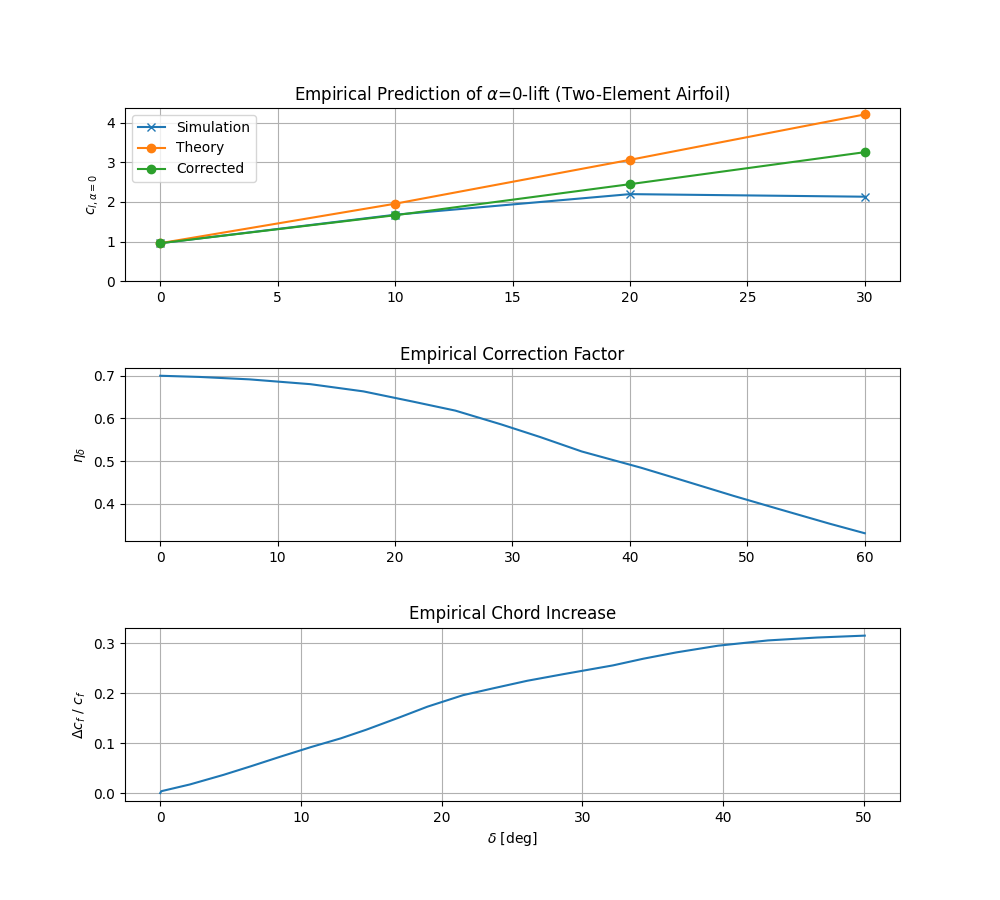

In [47]:
fig, ax = plt.subplots(3, 1, figsize = (10, 9), gridspec_kw={"hspace": 0.5})

series = torenbeek_df["cl_zero"].copy()
series.index += -DELTA_0
series.name = "Simulation"
series.plot(marker="x", ax=ax[0])
prediction_df.plot(marker="o", ax=ax[0])
ax[0].grid()
ax[0].legend()
ax[0].set_title("Empirical Prediction of $\\alpha$=0-lift (Two-Element Airfoil)")
ax[0].set_xlabel("")
ax[0].set_ylabel("$c_{l,\\alpha=0}$")
ax[0].set_ylim(0.0)

ETA.set_index("delta").plot(ax=ax[1], grid=True, legend=False)
ax[1].set_ylabel("$\eta_{\delta}$")
# ax[1].set_xlabel("$\delta$ [deg]")
ax[1].set_xlabel("")
ax[1].set_title("Empirical Correction Factor")

EMPIRICAL_CHORD_EXT.set_index("delta").plot(ax=ax[2], grid=True, legend=False)
ax[2].set_ylabel("$\Delta c_f \ / \ c_f$")
ax[2].set_xlabel("$\delta$ [deg]")
ax[2].set_title("Empirical Chord Increase")

# savefig("zero_aoa_lift_prediction_slot.png")

## Load distribution ratio

<IPython.core.display.Javascript object>


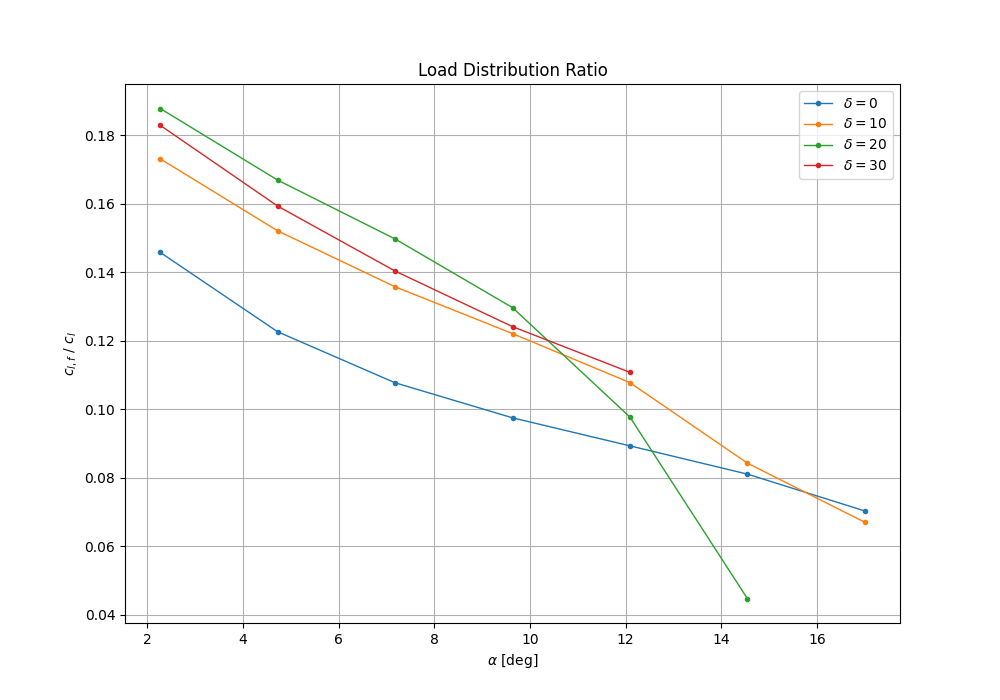

In [24]:
# LIFT
fig, ax = plt.subplots(1, 1)

color_exp = "black"

_deltas = list(results_per_delta.keys())

for delta in _deltas:

    # Unpack results
    _results = results_per_delta[delta].copy()
    # Filter results
    mask_error = _results["CL_error"].abs() < 0.1
    mask_alpha = _results["AOA"] > 0.0
    mask = mask_error & mask_alpha
    _results = _results.loc[mask]

    if _results.empty == True:
        continue

    if delta == 0.0:
        pass
        # color = color_exp
        # linewidth = 1.0
    else:
        color = None
        linewidth = 1.0

    # Lift polar
    ax.plot(
        _results["AOA"],
        _results["load_ratio"],
        marker=".",
        linestyle="-",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta-DELTA_0}$",
    )

ax.set_xlabel("$\\alpha$ [deg]")
ax.set_ylabel("$c_{l,f}$ / $c_{l}$")
ax.legend()
ax.grid()
ax.set_title("Load Distribution Ratio")

savefig(fname="load_distribution_slot.png")

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 